In [ ]:
import tensorflow as tf
import IPython.display as display
import PIL
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir1 = '/content/drive/MyDrive/Data Set /dataset/train'
dir2 = '/content/drive/MyDrive/Data Set /dataset/test'

data_dir = pathlib.Path(dir1)
test_dir = pathlib.Path(dir2)

print(data_dir)
print(test_dir)

/content/drive/MyDrive/Data Set /dataset/train
/content/drive/MyDrive/Data Set /dataset/test


**Number of Images**

In [ ]:
train_count = len(list(data_dir.glob('*/*.JPG')))
test_count = len(list(test_dir.glob('*/*.JPG')))

print(train_count)
print(test_count)

412
23


**Show Test Image**

In [ ]:
healthy_train = list(data_dir.glob('healthy/*'))
PIL.Image.open(str(healthy_train[0]))

Output hidden; open in https://colab.research.google.com to view.

**Image Generator**

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen_train = ImageDataGenerator(rescale = 1./255,
                                     validation_split = 0.2,
                                     rotation_range = 45,
                                     width_shift_range =.15,
                                     height_shift_range =.15,
                                     horizontal_flip = True,
                                     zoom_range =0.5)

In [ ]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     subset = 'training',
                                                     directory = data_dir,
                                                     shuffle = True,
                                                     target_size = (img_height, 
                                                                    img_width))

Found 330 images belonging to 2 classes.


In [ ]:
validation_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                          subset = 'validation',
                                                          directory=data_dir,
                                                          shuffle=True,
                                                          target_size=(img_height,
                                                                       img_width))

Found 82 images belonging to 2 classes.


**Class Labels**

In [ ]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.TXT"])
CLASS_NAMES

array(['diseased', 'healthy'], dtype='<U8')

In [ ]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
    plt.axis('off')

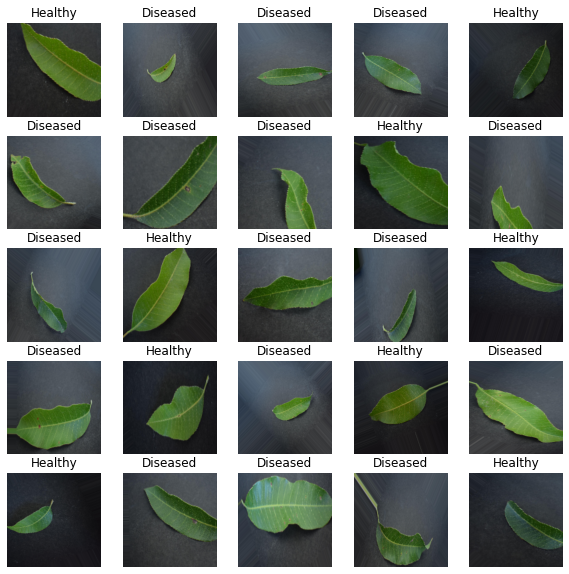

In [ ]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [ ]:
for image_batch, labels_batch in train_data_gen:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32, 2)


**Convolution Network**

In [ ]:
from tensorflow.keras import layers
num_classes = 2
model_mango = Sequential([
    Conv2D(16, 3, padding='same', activation='relu',
           input_shape=(img_height, img_width , 3)),
           MaxPooling2D(),
           Conv2D(32, 3, padding="same", activation='relu'),
           MaxPooling2D(),
           Conv2D(64, 3, padding='same', activation='relu'),
           MaxPooling2D(),
           Dropout(0.2),
           Flatten(),
          Dense(128, activation='relu'),
          Dense(num_classes)
])

In [ ]:
from tensorflow.python import metrics
model_mango.compile(optimizer='adam',
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    metrics=['accuracy'])

In [ ]:
model_mango.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 22, 22, 64)       0

**Model checkpoint to save best model to file**

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
rlr = ReduceLROnPlateau(patience=10, verbose= 1)
es = EarlyStopping(patience=24, restore_best_weights=True, verbose=1)
mc = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/model.h5', save_best_only=True, verbose=1)

**Fit the created model**

In [ ]:
epochs = 15
history = model_mango.fit(
  train_data_gen,
  callbacks=[rlr, es, mc],  
  validation_data=validation_data_gen,
  epochs=epochs
)

Epoch 1/15
11/11 [==============================] - ETA: 0s - loss: 0.5869 - accuracy: 0.5939 
Epoch 1: val_loss improved from inf to 0.47170, saving model to /content/drive/MyDrive/Colab Notebooks/model.hdf5
11/11 [==============================] - 216s 20s/step - loss: 0.5869 - accuracy: 0.5939 - val_loss: 0.4717 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/15
11/11 [==============================] - ETA: 0s - loss: 0.3528 - accuracy: 0.8667 
Epoch 2: val_loss improved from 0.47170 to 0.23820, saving model to /content/drive/MyDrive/Colab Notebooks/model.hdf5
11/11 [==============================] - 156s 14s/step - loss: 0.3528 - accuracy: 0.8667 - val_loss: 0.2382 - val_accuracy: 0.9146 - lr: 0.0010
Epoch 3/15
11/11 [==============================] - ETA: 0s - loss: 0.1551 - accuracy: 0.9576 
Epoch 3: val_loss improved from 0.23820 to 0.16229, saving model to /content/drive/MyDrive/Colab Notebooks/model.hdf5
11/11 [==============================] - 159s 15s/step - loss: 0.1551 - accur

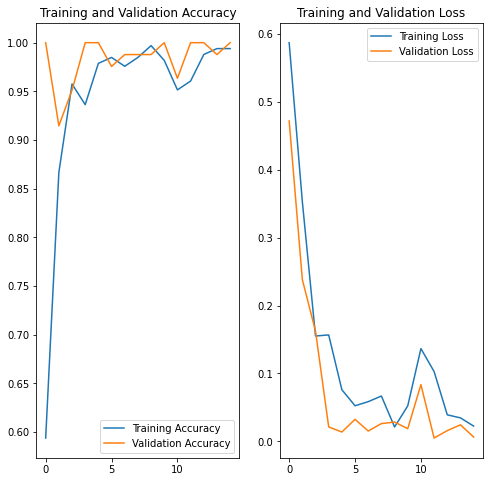

In [ ]:
model_mango = load_model('/content/drive/MyDrive/Colab Notebooks/model.h5')
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Plot Loss and Accuracy**

In [ ]:
image_gen_test = ImageDataGenerator(rescale = 1./255)
test_data_gen = image_gen_test.flow_from_directory(batch_size=32,
                                              directory= test_dir,
                                              shuffle=True,
                                              target_size=(img_height, img_width)
                                              )  

Found 23 images belonging to 2 classes.


In [ ]:
predictions = model_mango.predict(test_data_gen)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(CLASS_NAMES[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to diseased with a 100.00 percent confidence.


In [ ]:
predictions.shape

(23, 2)

In [ ]:
score2 = tf.nn.softmax(predictions)
score2

<tf.Tensor: shape=(23, 2), dtype=float32, numpy=
array([[9.99997377e-01, 2.68025883e-06],
       [9.99999881e-01, 1.07904114e-07],
       [1.00000000e+00, 1.48418628e-08],
       [1.00000000e+00, 7.89767626e-11],
       [1.67089704e-04, 9.99832869e-01],
       [1.00000000e+00, 3.33444349e-11],
       [1.00000000e+00, 8.28447935e-11],
       [1.00000000e+00, 1.73005235e-10],
       [1.94220687e-03, 9.98057783e-01],
       [1.00000000e+00, 1.78713755e-09],
       [9.99200347e-05, 9.99900103e-01],
       [5.70519042e-05, 9.99942899e-01],
       [6.22022781e-05, 9.99937773e-01],
       [9.99997854e-01, 2.11943734e-06],
       [1.00000000e+00, 1.87562197e-08],
       [3.67401954e-04, 9.99632597e-01],
       [1.55227288e-04, 9.99844790e-01],
       [9.99995112e-01, 4.91780293e-06],
       [1.00000000e+00, 3.29829827e-12],
       [9.85953302e-05, 9.99901414e-01],
       [1.00000000e+00, 2.86442137e-11],
       [1.00000000e+00, 7.02206460e-10],
       [7.56137670e-05, 9.99924421e-01]], dtype=f